In [1]:
import os
import random
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import networkx as nx
from itertools import combinations

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from torch.utils.data import Dataset, DataLoader

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv

from gensim.models import Word2Vec

**Embedding**
---

------

Load data

In [2]:
def parser(path):
    with open(path) as file:
        data = json.load(file)

    df = pd.json_normalize(data, record_path=['data'])
    return data, df

path = 'problems_2023_01_30/problems MoonBoard 2016 .json'

data, df = parser(path)
grade_df = df['grade']

Constructing initial graphs

In [3]:
def create_graph(moves, max_distance):
    G = nx.Graph()

    pos = {}
    nodes = []
    for move in moves:
        node = move['description']
        x = ord(node[0]) - ord('A') + 1
        y = 19 - int(node[1:])
        pos[node] = (x, y)
        nodes.append(node)
        G.add_node(node, isStart=move['isStart'], isEnd=move['isEnd'])
    
    distances = {node: {} for node in nodes}
    for n1, n2 in combinations(nodes, 2):
        dist = np.linalg.norm(np.array(pos[n1]) - np.array(pos[n2]))
        distances[n1][n2] = dist
        distances[n2][n1] = dist
    
    for node in nodes:
        sorted_neighbors = sorted(distances[node].items(), key=lambda item: item[1])
        closest_neighbors = [neighbor for neighbor, dist in sorted_neighbors[:2]]
        for neighbor in closest_neighbors:
            G.add_edge(node, neighbor, weight=distances[node][neighbor])
    
    for (n1, n2) in combinations(nodes, 2):
        if n2 not in G[n1] and distances[n1][n2] <= max_distance:
            G.add_edge(n1, n2, weight=distances[n1][n2])
    
    return G, pos

max_distance = 5

graphs_and_pos = []
for moves in df['moves']:
    graph, pos = create_graph(moves, max_distance)
    graphs_and_pos.append(graph)

Node embedding + example

In [4]:
def train_directed_embedding(graph):
    sentences = []
    for graph in graphs_and_pos:
        for node in graph.nodes():
            if graph.degree(node) > 0:
                context = [node] + list(graph.neighbors(node))
                sentences.append(context)

    model = Word2Vec(sentences, vector_size=3, window=1, min_count=1, sg=1, workers=4, epochs=10, max_final_vocab=198)

    return model

model = train_directed_embedding(graph)

In [5]:
node = 'K5'
if node in model.wv:
    node_vector = model.wv[node]
    print("Embedding for node", node, ":", node_vector)
else:
    print("Node", node, "not found in the model.")

Embedding for node K5 : [-0.10885483  1.8481146  -0.99618006]


Get all unique nodes/words in the model's dictionary

In [6]:
vocabulary = list(model.wv.key_to_index.keys()) 

In [7]:
embeddings = []
for node in vocabulary:
    embeddings.append((node, model.wv[node]))

Get average difficulty of each hold, for plotting purposes

In [8]:
def map_grades(grade):
    mapping = {
        '6B': 1, '6B+': 2, '6C': 3, '6C+': 4,
        '7A': 5, '7A+': 6, '7B': 7, '7B+': 8, '7C': 9, '7C+': 10,
        '8A': 11, '8A+': 12, '8B': 13, '8B+': 14, '8C': 15, '8C+': 16
    }
    return mapping.get(grade, None)

df['numeric_grade'] = df['grade'].apply(map_grades)

def parse_moves(moves):
    return [(move['description'], move['problemId']) for move in moves]

hold_list = []
for index, row in df.iterrows():
    problem_moves = parse_moves(row['moves'])
    for move, problem_id in problem_moves:
        hold_list.append({'hold': move, 'grade': row['numeric_grade'], 'problemId': problem_id})

holds_df = pd.DataFrame(hold_list)

average_difficulty_per_hold = holds_df.groupby('hold')['grade'].mean()

print(average_difficulty_per_hold)

hold
A10    5.777600
A11    6.311377
A12    5.600592
A13    5.631805
A14    4.214698
         ...   
K6     5.828851
K7     5.527076
K8     5.217048
K9     3.930869
j5     5.000000
Name: grade, Length: 142, dtype: float64


In [9]:
avg_diff = average_difficulty_per_hold

Plotting average difficulty of hold over number of apperances in all problems

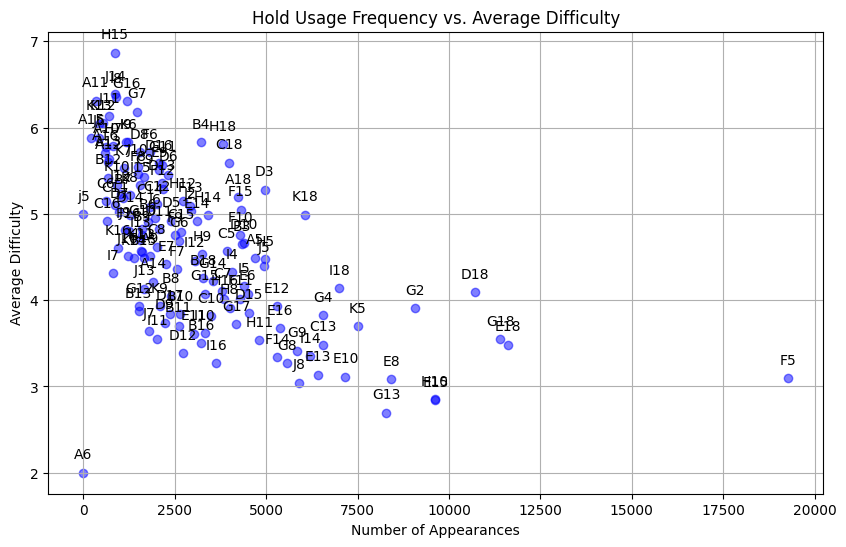

In [10]:
hold_counts = holds_df['hold'].value_counts()

average_difficulty_per_hold = holds_df.groupby('hold')['grade'].mean()

plot_df = pd.DataFrame({
    'NumAppearances': hold_counts,
    'AvgDifficulty': average_difficulty_per_hold
})

plot_df.reset_index(inplace=True)
plot_df.rename(columns={'index': 'Hold'}, inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(plot_df['NumAppearances'], plot_df['AvgDifficulty'], color='blue', alpha=0.5)

for i, point in plot_df.iterrows():
    plt.annotate(point['Hold'],
                 (point['NumAppearances'], point['AvgDifficulty']), 
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Hold Usage Frequency vs. Average Difficulty')
plt.xlabel('Number of Appearances')
plt.ylabel('Average Difficulty')

plt.grid(True)

# Show plot
plt.show()

Plot a 3D scatterplot of Node embeddings

In [17]:

labels = [label for label, _ in embeddings]
x_coords = [coords[0] for _, coords in embeddings]
y_coords = [coords[1] for _, coords in embeddings]
z_coords = [coords[2] for _, coords in embeddings]

fig = go.Figure(data=[go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    text=labels,
    mode='markers+text', 
    marker=dict(
        size=5,
        colorscale='Viridis', 
        opacity=0.8,
        colorbar=dict(title='Node Difficulty')
    ),
    textposition='top center'
)])

fig.update_layout(
    title='3D Visualization of Node Embeddings with Difficulty Scaling',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0) 
)

fig.show()

Div functions for constructing graphs and embeddings for RF grid search

In [18]:
def create_graph(moves, max_distance):
    G = nx.Graph()
    pos = {} 
    nodes = set()
    for move in moves:
        node = move['description']
        nodes.add(node)
        x = ord(node[0]) - ord('A') + 1
        y = 19 - int(node[1:])
        pos[node] = (x, y)
        G.add_node(node, isStart=move['isStart'], isEnd=move['isEnd'])

    for n1, n2 in combinations(nodes, 2):
        dist = np.linalg.norm(np.array(pos[n1]) - np.array(pos[n2]))
        if dist <= max_distance:
            G.add_edge(n1, n2, weight=dist) 

    return G, pos

def create_graph2(moves, max_distance):
    G = nx.Graph()
    pos = {} 
    nodes = set()
    for move in moves:
        node = move['description']
        nodes.add(node)
        x = ord(node[0]) - ord('A') + 1
        y = 19 - int(node[1:])
        pos[node] = (x, y)
        G.add_node(node, isStart=move['isStart'], isEnd=move['isEnd'])

    for n1, n2 in combinations(nodes, 2):
        dist = np.linalg.norm(np.array(pos[n1]) - np.array(pos[n2]))
        if dist <= max_distance:
            G.add_edge(n1, n2, weight=dist) 

    return G

def train_embedding(graphs, v_size=100, window=1, min_count=1, sg=1, epochs=10, mfv=198):
    sentences = []
    for graph in graphs:
        sentences.extend([list(graph.neighbors(node)) for node in graph.nodes() if graph.degree(node) > 0])
    
    model = Word2Vec(sentences, vector_size=v_size, window=window, min_count=min_count, sg=sg, workers=4, epochs=epochs, max_final_vocab=mfv)
    return model

def encode_grades(df, grade_mapping):
    df['grade_encoded'] = df['grade'].map(grade_mapping).fillna(-1).astype(int)
    return df

def aggregate_embeddings(moves_list, embeddings):
    embeddings_list = [embeddings[move['description']] for move in moves_list if move['description'] in embeddings]
    return np.mean(embeddings_list, axis=0) if embeddings_list else np.zeros(100)

Mapping problem difficulty

In [19]:
grade_mapping = {
    '6B+': 0, '6C': 1, '6C+': 2, '7A': 3, '7A+': 4,
    '7B': 5, '7B+': 6, '7C': 7, '7C+': 8, '8A': 9,
    '8A+': 10, '8B': 11, '8B+': 12
}

df_encoded = encode_grades(df, grade_mapping)

Grid search W2V parameters

In [20]:
dist_list = [4,5,6,7,8,9,10]
emb_list = [3, 10, 50, 100]
window_list = [1,2,3]

In [ ]:
for dist in dist_list:
    for emb in emb_list:
        for w in window_list:
            max_distance = dist
            graphs_and_pos = [(create_graph(moves, max_distance), index) for index, moves in enumerate(df['moves'])]
            graphs = [graph for graph, _ in graphs_and_pos]

            model = train_embedding(graphs, v_size=emb, window=w)

            df_encoded['aggregated_embeddings'] = df_encoded['moves'].apply(lambda x: aggregate_embeddings(x, model.wv))
            X = pd.DataFrame(df_encoded['aggregated_embeddings'].tolist())
            y = df_encoded['grade_encoded']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            classifier.fit(X_train, y_train)

            predictions = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            print(f"Distance: {dist}, Emb: {emb}, Window: {w}, Accuracy: {accuracy:.2%}")

Optimal calibration: v_size=50, window=2

In [22]:
max_distance = 9
graphs_and_pos = [create_graph(moves, max_distance) for moves in df['moves']]
graph_list = [(create_graph2(moves, max_distance), index) for index, moves in enumerate(df['moves'])]
graphs = [graph for graph, _ in graphs_and_pos]

model = train_embedding(graphs, v_size=50, window=2) 

df_encoded['aggregated_embeddings'] = df_encoded['moves'].apply(lambda x: aggregate_embeddings(x, model.wv))
X = pd.DataFrame(df_encoded['aggregated_embeddings'].tolist())
y = df_encoded['grade_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Distance: {dist}, Emb: {emb}, Window: {w}, Accuracy: {accuracy:.2%}")

Distance: 4, Emb: 3, Window: 1, Accuracy: 37.60%


**GNN**
---

-----

Check if node exist in vocab

In [23]:
filtered_graphs = []

for graph in graph_list:
    graph_nodes = set(graph[0].nodes())
    if graph_nodes.issubset(vocabulary):
        filtered_graphs.append((graph[0], graph[1]))

In [26]:
x = []
for node in vocabulary:
    try:
        x.append((node, model.wv[node]))
    except:
        print(node, "missing node")

j5 missing node


In [27]:
vocabulary = list(model.wv.key_to_index.keys()) 

Attach embeddings to graph

In [28]:
embedding_dict = dict(x)

for graph in filtered_graphs:
    for node in graph[0].nodes():
        if node in embedding_dict:
            embedding = embedding_dict[node]
            nx.set_node_attributes(graph[0], {node: embedding}, name='embedding')

Convert nxGraph to PyTorch graph

In [29]:
data_list = []
node_to_index = {}
index_counter = 0

for graph, _ in graph_list:
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    
    node_features = []
    for node in graph.nodes():
        if 'embedding' in graph.nodes[node]:
            node_features.append(graph.nodes[node]['embedding'])
        else:
            node_features.append([0.0] * 50)
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    for node in graph.nodes():
        if node not in node_to_index:
            node_to_index[node] = index_counter
            index_counter += 1
    
    edge_list = [(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in graph.edges()]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    
    data = Data(x=node_features, edge_index=edge_index)
    data_list.append(data)

/var/folders/69/80h6lkms4pv5z1ttzkp1p9dr0000gn/T/ipykernel_26569/628461002.py:20: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)



Define GCN structure

In [30]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels=50, hidden_channels=16, out_channels=14):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 30)
        self.conv2 = GCNConv(30, 20)
        self.conv3 = GCNConv(20, 14)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

Graph conversion function

In [31]:
def graph_to_data(graph_tuple):
    graph, target = graph_tuple
    node_embeddings = list(nx.get_node_attributes(graph, 'embedding').values())
    x = torch.tensor(node_embeddings, dtype=torch.float)
    
    node_to_index = {node: index for index, node in enumerate(graph.nodes())}
    edge_index = torch.tensor([[node_to_index[e[0]], node_to_index[e[1]]] for e in graph.edges()]).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=target)

Define model

In [32]:
input_dim = 50
model = GCN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Collect and train/test split

In [33]:
data_list = [graph_to_data(graph_tuple) for graph_tuple in graph_list]

In [34]:
def custom_collate(batch):
    return Batch.from_data_list(batch)

loader = DataLoader(data_list, batch_size=64, shuffle=True, collate_fn=custom_collate)

In [35]:
label_encoder = LabelEncoder()
df['grade_encoded'] = label_encoder.fit_transform(df['grade'])

In [36]:
def split_list(lst, percentage):
    random.shuffle(lst)
    split_index = int(len(lst) * percentage)
    first_list = lst[:split_index]
    second_list = lst[split_index:]
    return first_list, second_list

In [37]:
train_list, test_list = split_list(graph_list, 0.9)

Training loop

In [39]:
model.train()
epochs = 50
loss_list = []
tot_loss = []
for epoch in range(epochs):
    total_loss = 0
    for graph_tuple in train_list:
        try:
            graph, target_idx = graph_tuple
            optimizer.zero_grad()
            data = graph_to_data(graph_tuple)
            out = model(data.x, data.edge_index)
            target = torch.tensor(df.loc[target_idx, 'grade_encoded'], dtype=torch.float)
            loss = criterion(torch.mean(out), target)
            loss_list.append(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except:
            pass
    average_loss = total_loss / len(graph_list)
    tot_loss.append(average_loss)
    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

Epoch 1, Average Loss: 3.796505780980161
Epoch 2, Average Loss: 3.63515879681019
Epoch 3, Average Loss: 3.5941786482108973
Epoch 4, Average Loss: 3.6095631882146173
Epoch 5, Average Loss: 3.583230665585337
Epoch 6, Average Loss: 3.549264963950644
Epoch 7, Average Loss: 3.489212269561837
Epoch 8, Average Loss: 3.459158214061005
Epoch 9, Average Loss: 3.4564998456599034
Epoch 10, Average Loss: 3.4367277530605023
Epoch 11, Average Loss: 3.4322817568409953
Epoch 12, Average Loss: 3.4290260321550483
Epoch 13, Average Loss: 3.424266846764709
Epoch 14, Average Loss: 3.4171406647144127
Epoch 15, Average Loss: 3.414566971851611
Epoch 16, Average Loss: 3.4149376022608844
Epoch 17, Average Loss: 3.4117060181309324
Epoch 18, Average Loss: 3.4065202051259207
Epoch 19, Average Loss: 3.4124865336021757
Epoch 20, Average Loss: 3.4022722943593156
Epoch 21, Average Loss: 3.3896532773252495
Epoch 22, Average Loss: 3.3974771729846807
Epoch 23, Average Loss: 3.3907209123090305
Epoch 24, Average Loss: 3.390

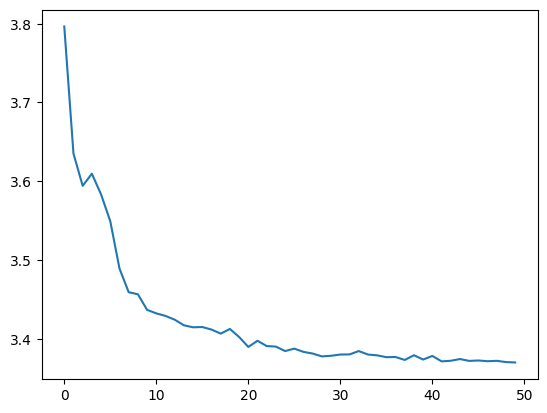

In [40]:
plt.plot(tot_loss)

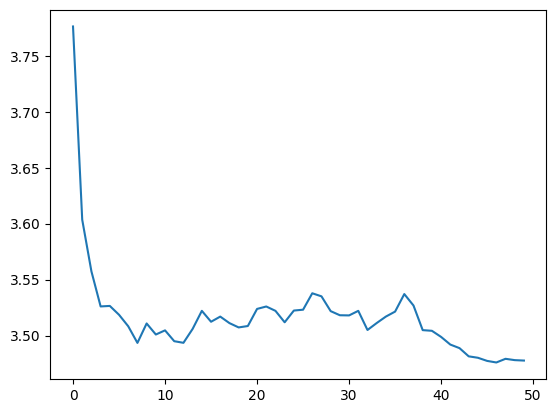

Evaluation loop

In [44]:
model.eval()

correct_predictions = 0
total_samples = 0

test_loss_list = []

with torch.no_grad():
    for graph_tuple in test_list:
        try:
            graph, target_idx = graph_tuple
            data = graph_to_data(graph_tuple)
            out = model(data.x, data.edge_index)

            pred = torch.mean(out)
            target = torch.tensor(df.loc[target_idx, 'grade_encoded'], dtype=torch.float).item()
            loss = criterion(torch.mean(out), torch.tensor(target))
            test_loss_list.append(loss.item())
            
            total_samples += 1

            if int(pred.item()) == target: 
                correct_predictions += 1
        except Exception as e:
            print(f"Error processing sample: {e}")
            pass

accuracy = correct_predictions / total_samples
average_test_loss = sum(test_loss_list) / total_samples

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_test_loss}')

Accuracy: 29.93%
Average Test Loss: 3.533875524579506
